In [1]:
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass


# helper functions 
from importlib import reload 
import module 

### Plotting function

In [2]:

# Inputs: arrays of annual discounted costs for EV and ICE, and length of time to plot
# Outputs: line plot of cumulative costs (discounted) of EV and ICE over time period
def plot_cumulative_costs(EV, ICE):
    costs_EV = EV.get_annual_discounted_costs()
    costs_ICE = ICE.get_annual_discounted_costs()
    years  = np.arange(0, len(costs_EV))
    plt.title("Cumulative Costs ($), \n EV (retrofit) vs ICE (refurbished)", size = 18)
    plt.xlabel("Years")
    plt.ylabel("Cost ($)")
    plt.plot(years[1:], np.cumsum(costs_EV[1:]), color = 'blue', label = 'EV', marker = 'o')
    plt.plot(years[1:], np.cumsum(costs_ICE[1:]), color = 'red', label = 'ICE', marker = 'o')
    plt.legend()
    plt.show()

# TODO: 

(in no particular order)
1. <font color = 'yellow'> Read in parameters as data load in or user input. </font>
1. <font color = 'red'> Upgrade the EV charge simulation, possibly based on data or heuristics (needs a discussion) </font>
2. <font color = 'orange'> Currently hard-coded as year on year analysis, may want to make this dynamic </font>
3. <font color = 'orange'> Include end of life EV value somehow </font> 
4. <font color = 'yellow'> Include rebuy cost for the vehicle with the shorter lifespan in the main function? </font>
5. <font color = 'yellow'> Amortization schedule function is clunk so fix. No need for pandas df </font>
6. <font color = 'orange'> Simulate 'roaming' charging profile like normal charging profile and use for EV roaming revenue calcs </font>
7. <font color = 'yellow'> Separate out EV charging station service life from vehicle service life (.. or not? have discussion) </font>

key: 
<font color = 'red'> hard </font>,
<font color = 'orange'> medium </font>,
<font color = 'yellow'> easy </font> </br>

# Classes

### Data classes
In practice, to be instantiated with user input or loaded data

In [3]:
@dataclass
class ChargingPort: 
    charging_power: float 
    charging_efficiency: float 
    capex: float 
    roaming: bool
    roaming_pct: float
    annual_opex: float

@dataclass 
class MarketEnvironment:
    interest_rate: float 
    inflation_rate: float 
    price_diesel: float 
    price_electricity: float 
    time_of_use_tariffs: dict
    time_periods: dict
    price_diesel_annual_growth_rate: float 
    price_electricity_annual_growth_rate: float 
    discount_rate: float 
 
@dataclass    
class FinancingMechanism:
    loan_lifetime: int 
    installment_schedule: int 
    

### Vehicle 
(for ICE vehicles / parent class of EV alternative)

In [4]:
class Vehicle:
    KGCO2EQ_PER_L_DIESEL = 2.3 # kgCO2/L
    
    def __init__(self, model: str, params: dict, market_environment, financing_mechanism):
    
        self.model = model
        self.daily_mileage = params['daily_mileage'] # km/day
        self.days_worked_per_week = params['days_worked_per_week'] # days/week
        self.weeks_worked_per_year = params['weeks_worked_per_year'] # weeks/year
        self.fuel_economy = params['fuel_economy'] # L/100km
        self.service_life = params['service_life'] # years
        self.capex = params['ICE_capex'] # $/vehicle
        self.down_payment = params['down_payment_fraction'] * self.capex # $/vehicle
        self.rebuy_value = params['rebuy_value_fraction'] * self.capex # $/vehicle
        
        # Other operating costs
        self.annual_maintenance_cost = params['annual_maintenance_cost'] # $/year
        self.annual_insurance_cost = params['annual_insurance_cost'] # $/year
        self.annual_taxes = params['annual_taxes'] # $/year
        
        # data classes
        self.market_environment = market_environment
        self.financing_mechanism = financing_mechanism
        
        
    def __repr__(self):
        return f"ICE(id = {repr(self.model)}, daily_mileage = {repr(self.daily_mileage)}, days_worked_per_week = {repr(self.days_worked_per_week)}, weeks_worked_per_year = {repr(self.weeks_worked_per_year)}, fuel_economy = {repr(self.fuel_economy)}, annual_maintenance_cost = {repr(self.annual_maintenance_cost)})"  
        
    
    ### Computed properties
    @property
    def loan_amount(self):
        return self.capex - self.down_payment
    
    @property
    def annual_mileage(self):
        return self.daily_mileage * self.days_worked_per_week * self.weeks_worked_per_year
    
    @property 
    def annual_fuel_consumption(self):
        return self.annual_mileage * self.fuel_economy / 100
    
    @property 
    def annual_carbon_emissions(self):
        return self.annual_fuel_consumption * Vehicle.KGCO2EQ_PER_L_DIESEL
    
    # Costs
    @property 
    def amortization_schedule(self):
        loan_amount = -self.loan_amount
        interest_rate_per_period = self.market_environment.interest_rate / self.financing_mechanism.installment_schedule
        periods = self.financing_mechanism.loan_lifetime * self.financing_mechanism.installment_schedule # monthly payback
        n_periods = np.arange(periods) + 1
    
        ##### BUILD AMORTIZATION SCHEDULE #####
        # Interest 
        interest_monthly = npf.ipmt(interest_rate_per_period, n_periods, periods, loan_amount)
    
        # Principal 
        principal_monthly = npf.ppmt(interest_rate_per_period, n_periods, periods, loan_amount)
    
        # Join data in dataframe
        df = pd.DataFrame({
            'Period': n_periods,
            'Interest': interest_monthly,
            'Principal': principal_monthly
        })
    
        # Monthly Loan Payment
        df['Payment'] = df['Interest'] + df['Principal']
    
        # Cumsum Loan Payments
        df['Balance'] = df['Payment'].cumsum()
    
        # Reverse vals to pay down balance
        df['Balance'] = df['Balance'].values[::-1]
    
        return df
    
    @property 
    def capital_financing_costs(self):
        cap_fin_cost = np.zeros(self.financing_mechanism.loan_lifetime)
        cap_fin_cost[0] = -self.capex
        annual_loan_payment = self.amortization_schedule.iloc[0:self.financing_mechanism.installment_schedule].sum()['Payment']
        cap_fin_cost[1:self.financing_mechanism.loan_lifetime + 1] = annual_loan_payment
        return cap_fin_cost
    
    @property
    def operating_cost_fuel(self):
        #Fuel Costs
        operating_cost_fuel = np.full(self.service_life, self.market_environment.price_diesel * self.annual_fuel_consumption)
        operating_cost_fuel[0] = 0
        
        # Adjust fuel cost for annual growth rate
        for idx,val in enumerate(operating_cost_fuel):
            if idx != 0:
                operating_cost_fuel[idx] = operating_cost_fuel[idx] * (1+self.market_environment.price_diesel_annual_growth_rate)**(idx-1)
        
        return operating_cost_fuel

    @property
    def operating_cost_other(self):
        operating_cost_other = np.full(self.service_life, self.annual_insurance_cost + self.annual_maintenance_cost + self.annual_taxes)
        operating_cost_other[0] = 0 # 0 operating costs in year 0 (before the purchase is made)
        
        return operating_cost_other
    
    @property
    def operating_cost_total(self):
        return self.operating_cost_fuel + self.operating_cost_other
    
    @property
    def annual_costs(self):
        # identify which list is shorter between self.capital_financing_Costs and self.operating_Cost_total
        # if self.capital_financing_costs is shorter, pad it with zeros
        # if self.operating_cost_total is shorter, pad it with zeros
        # sum the two lists
        # return the sum
        
        capital_financing_costs = self.capital_financing_costs
        operating_cost_total = self.operating_cost_total
        
        if len(capital_financing_costs) <= len(operating_cost_total):
            capital_financing_costs = np.pad(capital_financing_costs, (0, len(operating_cost_total) - len(capital_financing_costs)), 'constant')
        else:
            operating_cost_total = np.pad(operating_cost_total, (0, len(capital_financing_costs) - len(operating_cost_total)), 'constant')
        
    
        return [cap_fin_cost + op_cost for cap_fin_cost, op_cost in zip(capital_financing_costs, operating_cost_total)]
    
    
    def get_annual_discounted_costs(self):
            
        cost_annual_discounted = self.annual_costs
        
        for year in range(len(cost_annual_discounted)):
            cost_annual_discounted[year] = cost_annual_discounted[year] * (1/(1+self.market_environment.discount_rate))**year
    
        return cost_annual_discounted
    
    def get_end_of_life_value(self):   
        return self.rebuy_value
    

### EV subclass

In [5]:
class EV(Vehicle):
    GRID_CARBON_INTENSITY = 0.95 # kgCO2/kWh
    

    def __init__(self, model: str, params: dict, charging_port, market_environment, financing_mechanism):
        super().__init__(model, params, market_environment, financing_mechanism)
        self.model = model # string
        self.efficiency = params['efficiency'] # kWh/km
        self.battery_capacity = params['battery_capacity'] # kWh
        
        self._needs_new_charging_port = params['needs_new_charging_port'] # boolean
        self._charging_profile = None # kWh
        
        
        # data classes
        self.charging = charging_port
        self.market_environment = market_environment
        self.financing_mechanism = financing_mechanism
        
        if self._needs_new_charging_port:
            self.capex = params['EV_capex'] + self.charging.capex # $
        else:
            self.capex = params['EV_capex'] # $
            
        
        
    def __repr__(self):
        return f"EV(id={repr(self.model)}, battery_capacity={repr(self._battery_capacity)}, charging_power={repr(self.charging.charging_power)})"
    
    
    # Efficiency getter and setter (for later on when we want to be able to change efficiency of vehicle and have it affect the charging profile without reinstantiating class)
    @property
    def efficiency(self):
        return self._efficiency
    
    @efficiency.setter
    def efficiency(self, efficiency):
        self._charging_profile = None
        self._efficiency = efficiency
        
    # Battery capacity getter and setter
    @property 
    def battery_capacity(self):
        return self._battery_capacity
    
    @battery_capacity.setter
    def battery_capacity(self, battery_capacity):
        self._charging_profile = None # reset charging profile when battery capacity is changed 
        self._battery_capacity = battery_capacity
    
        
    # Charging profile (simulated or data loaded)
    @property 
    def charging_profile(self):
        # cache 
        if self._charging_profile is None: # cache when not None 
            total_days = 365  # Total number of days to simulate
            total_time = 24 * total_days  # Total simulation time in hours
            time_resolution = 1  # Time resolution in hours (e.g., 0.25 means 15 minutes)
            self._charging_profile = module.simulate_charging_load_profile(total_days, total_time, time_resolution, 1, self.charging.charging_power, plot = False)
        return self._charging_profile
        
    # Monetary costs
    @property
    def annual_electricity_costs(self):
        return module.get_cost_of_charging(self.charging_profile, self.market_environment.time_of_use_tariffs, self.market_environment.time_periods)
        
    @property
    def operating_cost_fuel(self):
        #Fuel Costs
        operating_cost_fuel = np.full(self.service_life, self.annual_electricity_costs)
        operating_cost_fuel[0] = 0
        
        # Adjust fuel cost for annual growth rate
        for idx,val in enumerate(operating_cost_fuel):
            if idx != 0:
                operating_cost_fuel[idx] = operating_cost_fuel[idx] * (1+self.market_environment.price_electricity_annual_growth_rate)**(idx-1)
                

        return operating_cost_fuel
    
    #TODO: separate out charing station service life from EV service life...? 
    #TODO: ^think about the time horizon of investment analysis desired for the output of the tool / for a research papaer
    @property 
    def operating_cost_charging_station(self):
        if self._needs_new_charging_port:
            return np.full(self.service_life, self.charging.annual_opex)
        else:
            return 0 
        
    #TODO: Simulate a 'roaming' charging profile like the normal charging profile. 
    @property 
    def roaming_revenue(self):
        if self.charging.roaming:
            return np.full(self.service_life, self.market_environment.price_electricity * self.charging.roaming_pct * 8760) # 8760 hours in a year
        else:
            return 0 
        
    @property
    def operating_cost_total(self):
        return self.operating_cost_fuel + self.operating_cost_other + self.operating_cost_charging_station - self.roaming_revenue 
    
    
    # Carbon emissions 
    @property 
    def annual_carbon_emissions(self):
        kWh_used = sum(self.charging_profile)
        return kWh_used * EV.GRID_CARBON_INTENSITY
    
        

# Main

## Initialize parameters 
(in future to be user input or loaded from data file)

In [10]:
vehicle_params = {'daily_mileage': 100, 'days_worked_per_week': 5, 'weeks_worked_per_year': 50, 'fuel_economy': 10, 'service_life': 10, 
                  'down_payment_fraction': 0.2, 'annual_maintenance_cost': 1000, 'annual_insurance_cost': 1000, 'annual_taxes': 1000, 
                  'efficiency': 0.2, # kWh/km 
                  'battery_capacity': 30, 
                  'EV_capex': 20000, 
                  'ICE_capex': 10000,
                  'needs_new_charging_port': True,
                  'rebuy_value_fraction': 0.50} # if True, then includes the charging port capex

charging_port_params = {'charging_power': 7.2, 'charging_efficiency': 0.9, 
                        'capex': 10000,
                        'roaming': True,
                        'roaming_pct': 0.10, 
                        'annual_opex': 1000} 

market_params = {'price_electricity': 0.08, 'price_electricity_annual_growth_rate': 0.02, 
                 'price_diesel': 1.20, 'price_diesel_annual_growth_rate': 0.10, 
                 'discount_rate': 0.10, 'inflation_rate': 0.02,
                 'interest_rate': 0.07,
                 'time_of_use_tariffs': {'morning': 0.10, 'afternoon': 0.15, 'evening': 0.20, 'night': 0.10},
                 'time_periods': {'morning_start': 5, 'afternoon_start': 11, 'evening_start': 17, 'night_start': 21}}

financing_params = {'loan_lifetime': 5, # years
                    'installment_schedule': 12} # payments per year 


In [7]:
vehicle_params = {}

vehicle_params['daily_mileage'] = float(input("Enter daily mileage: "))
vehicle_params['days_worked_per_week'] = int(input("Enter days worked per week: "))
vehicle_params['weeks_worked_per_year'] = int(input("Enter weeks worked per year: "))
vehicle_params['fuel_economy'] = float(input("Enter fuel economy: "))
vehicle_params['service_life'] = int(input("Enter service life: "))
vehicle_params['down_payment_fraction'] = float(input("Enter down payment fraction: "))
vehicle_params['annual_maintenance_cost'] = float(input("Enter annual maintenance cost: "))
vehicle_params['annual_insurance_cost'] = float(input("Enter annual insurance cost: "))
vehicle_params['annual_taxes'] = float(input("Enter annual taxes: "))
vehicle_params['efficiency'] = float(input("Enter efficiency (kWh/km): "))
vehicle_params['battery_capacity'] = float(input("Enter battery capacity: "))
vehicle_params['EV_capex'] = float(input("Enter EV capex: "))
vehicle_params['ICE_capex'] = float(input("Enter ICE capex: "))
vehicle_params['firstEV'] = input("Is it the first EV? (True/False): ") == 'True'

charging_port_params = {}

charging_port_params['charging_power'] = float(input("Enter charging power: "))
charging_port_params['charging_efficiency'] = float(input("Enter charging efficiency: "))
charging_port_params['capex'] = float(input("Enter charging port capex: "))

market_params = {}

market_params['price_electricity'] = float(input("Enter price of electricity: "))
market_params['price_electricity_annual_growth_rate'] = float(input("Enter annual growth rate of electricity price: "))
market_params['price_diesel'] = float(input("Enter price of diesel: "))
market_params['price_diesel_annual_growth_rate'] = float(input("Enter annual growth rate of diesel price: "))
market_params['discount_rate'] = float(input("Enter discount rate: "))
market_params['inflation_rate'] = float(input("Enter inflation rate: "))
market_params['interest_rate'] = float(input("Enter interest rate: "))

time_of_use_tariffs = {}

time_of_use_tariffs['morning'] = float(input("Enter morning time of use tariff: "))
time_of_use_tariffs['afternoon'] = float(input("Enter afternoon time of use tariff: "))
time_of_use_tariffs['evening'] = float(input("Enter evening time of use tariff: "))
time_of_use_tariffs['night'] = float(input("Enter night time of use tariff: "))

market_params['time_of_use_tariffs'] = time_of_use_tariffs

time_periods = {}

time_periods['morning_start'] = int(input("Enter morning start time: "))
time_periods['afternoon_start'] = int(input("Enter afternoon start time: "))
time_periods['evening_start'] = int(input("Enter evening start time: "))
time_periods['night_start'] = int(input("Enter night start time: "))

market_params['time_periods'] = time_periods

financing_params = {}

financing_params['loan_lifetime'] = int(input("Enter loan lifetime (in years): "))
financing_params['installment_schedule'] = int(input("Enter number of payments per year: "))


ValueError: could not convert string to float: ''

## Instantiate classes

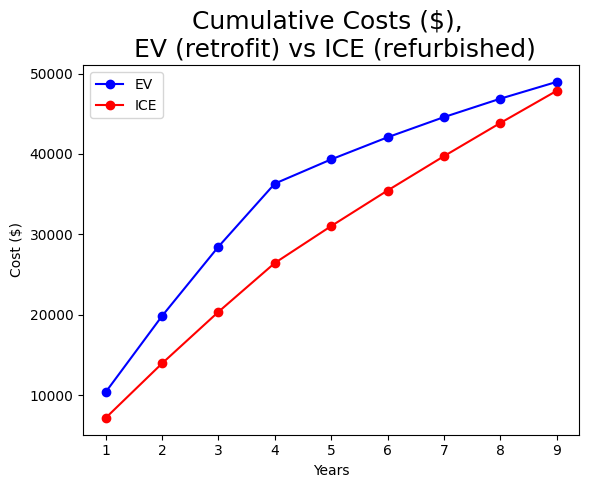

In [11]:
reload(module)

charging_port1 = ChargingPort(**charging_port_params)
market_environment1 = MarketEnvironment(**market_params)
financing_mechanism1 = FinancingMechanism(**financing_params)  


vehicle1 = Vehicle(1, vehicle_params, market_environment = market_environment1, financing_mechanism = financing_mechanism1)
ev1 = EV(vehicle1, vehicle_params, charging_port1, market_environment1, financing_mechanism1)
plot_cumulative_costs(ev1, vehicle1)
plt.show()

## Results

In [20]:
print("ICEV emits: ", round(vehicle1.annual_carbon_emissions, 2), "kgCO2eq/year")
print("EV emits: ", round(ev1.annual_carbon_emissions, 2), "kgCO2eq/year")

ICEV emits:  5750.0 kgCO2eq/year
EV emits:  6224.4 kgCO2eq/year
